In [ ]:
# !unzip "/content/drive/MyDrive/diabetic-retinopathy.zip" -d "drive/MyDrive/DiabeticRetinopathy"
# Unzipping Dataset File

In [ ]:
# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TensorFlow Version : ", tf.__version__)
print("TensorFlow Hub Version : ", hub.__version__)
# Check For GPU Availability
print("GPU", "Available (YES!)" if tf.config.list_physical_devices("GPU") else "Not Available :(")

TensorFlow Version :  2.12.0
TensorFlow Hub Version :  0.13.0
GPU Available (YES!)


In [ ]:
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning) # Handle Deprecation Warnings

In [ ]:
# Checkout the labels of our data

import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/DiabeticRetinopathy/train.csv")
labels_csv.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

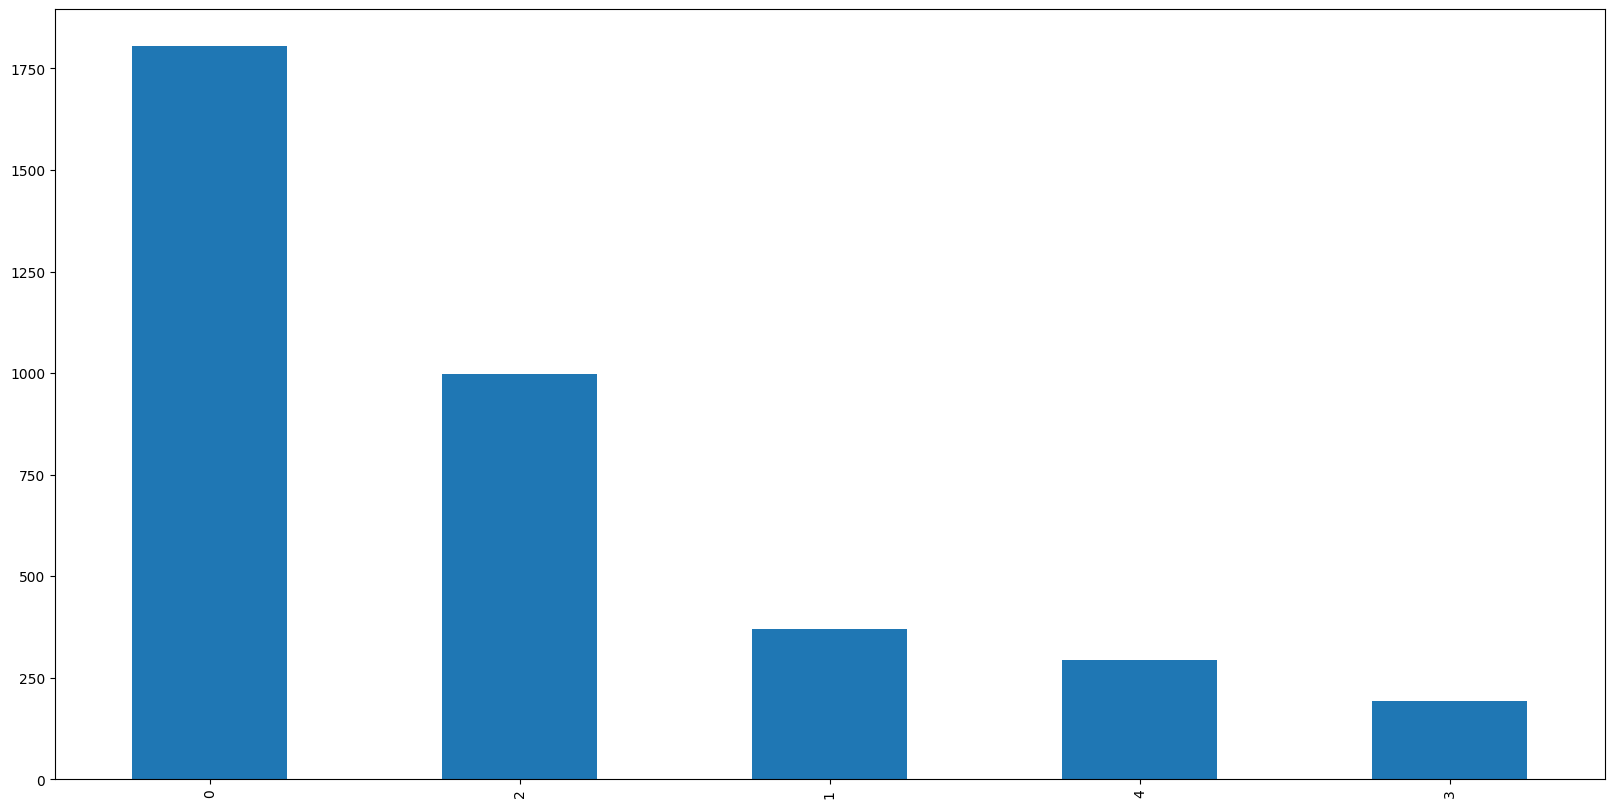

In [ ]:
# How many images are there of each severity?

labels_csv.diagnosis.value_counts().plot.bar(figsize = (20, 10));

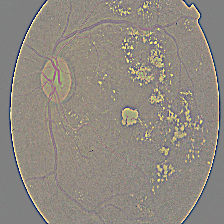

In [ ]:
# Let's view an image

from IPython.display import Image
Image("/content/drive/MyDrive/DiabeticRetinopathy/gaussian_filtered_images/gaussian_filtered_images/Severe/0104b032c141.png")

### Getting Images & Their Labels

Let's get a list of all our image file pathnames as the filenames are too long

In [ ]:
labels_csv.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [ ]:
# Labels Dictionary
labels_dict = { 0: "No_DR",
                1: "Mild",
                2: "Moderate",
                3: "Severe",
                4: "Proliferate_DR" }

# Create pathnames from image IDs
filenames = []
for i in range(0, len(labels_csv)):
    filenames.append("drive/MyDrive/DiabeticRetinopathy/gaussian_filtered_images/gaussian_filtered_images/"+ labels[labels_csv["diagnosis"][i]] + "/" + labels_csv["id_code"][i] + ".png")

# Check the first 10
filenames[:10]

In [ ]:
# Check whether the number of file names matches the actual number of image files

if len(labels_csv) == len(filenames):
  print("Filenames match actual amount of files. Good to go :)")
else:
  print("Filenames do not match actual amount of files. Check the target directory :(")

Filenames match actual amount of files. Good to go :)


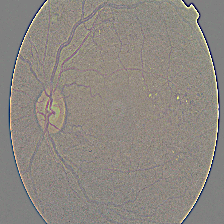

In [ ]:
# One More Check

Image(filenames[3000])

In [ ]:
# What severity level is that?

labels[labels_csv["diagnosis"][3000]]

'Moderate'

Since we've got our training image file paths in a list, let's prepare our labels

In [ ]:
import numpy as np
labels = labels_csv["diagnosis"]
labels = np.array(labels) # We can also do : to_numpy()
labels

array([2, 4, 1, ..., 2, 0, 2])

In [ ]:
len(labels)

3662

In [ ]:
# Check if number of labels matches number of images (Check for missing data easily)
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames :)")
else:
  print("Number of labels does not match number of filenames :(")

Number of labels matches number of filenames :)


In [ ]:
# Check if all labels are unique
unique_categories = np.unique(labels)
len(unique_categories)

5

In [ ]:
# Turn every label into a boolean array (Compare with all categories and the only True value will be the category it belongs to)

print(labels[0])
labels[0] == unique_categories

2


array([False, False,  True, False, False])

In [ ]:
# Do this for all labels

boolean_labels = [label == unique_categories for label in labels]
boolean_labels[:2]

[array([False, False,  True, False, False]),
 array([False, False, False, False,  True])]

In [ ]:
len(boolean_labels)

3662

In [ ]:
# Turning a boolean array into an array of integers

print(labels[0]) # Label 0
print(boolean_labels[0].argmax()) # Index Where It's Category Exists
print(boolean_labels[0].astype(int)) # There Will Be A 1 at 3rd Index

2
2
[0 0 1 0 0]


### Creating a validation set

Since the data from Kaggle doesn't come with a validation set, we'll create our own validation set

In [ ]:
# Setup X and y variables

X = filenames
y = boolean_labels

In [ ]:
len(filenames)

3662

### We're going to start off experimenting with ~1000 images and increase as we need

In [ ]:
# Set number of images to be used for experimenting (Usually parameters are set as all capitals)
NUM_IMAGES = 3662 #@param {type: "slider", min:1000, max:10000}

# Created a slider

In [ ]:
# Let's split our data using Scikit-Learn's train-test-split
from sklearn.model_selection import train_test_split

# Split into training & validation sets of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)

(2929, 2929, 733, 733)

In [ ]:
# Let's have a gaze at the training data (filenames & boolean_labels)
X_train[0], y_train[0]

('drive/MyDrive/DiabeticRetinopathy/gaussian_filtered_images/gaussian_filtered_images/No_DR/996f9bba4ef0.png',
 array([ True, False, False, False, False]))

## Preprocessing Images (Turning Images Into Tensors)

To preprocess our images into tensors, let's write a function that does a few things:
1. Take an image file path as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (Convert 0-255 values to 0-1 values)
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape # Height, Width, Colour Channel (RGB)

(224, 224, 3)

In [ ]:
image.max(), image.min() # All values are pixel brightness values between 0 and 255

(1.0, 0.0)

In [ ]:
# Our training images are already reshaped and normalized, but we'll define a function for the sake of testing on custom images
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpg image into a numerical tensor with three color channels (RGB)
  image = tf.image.decode_jpeg(image, channels = 3)

  # Convert the colour channel values from 0-255 values to 0-1 values (Image Representation Using Floating Points Needs 0-1 Values)
  image = tf.image.convert_image_dtype(image, tf.float32) # Normalization !

  # Resize our image to our desired size (224,224)
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
tensor = tf.io.read_file(filenames[0]) # Unreadable string
tensor = tf.image.decode_jpeg(tensor, channels = 3)
tensor = tf.image.convert_image_dtype(tensor, tf.float32)
tensor = tf.image.resize(tensor, size = [224,224])
tensor[:2]

# Trying out the function line by line

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.5019608 , 0.5019608 , 0.5019608 ],
        [0.5176471 , 0.5019608 , 0.5019608 ],
        [0.5019608 , 0.5176471 , 0.5176471 ],
        ...,
        [0.48627454, 0.5019608 , 0.5019608 ],
        [0.5019608 , 0.48627454, 0.5019608 ],
        [0.5137255 , 0.5019608 , 0.5019608 ]],

       [[0.5176471 , 0.5019608 , 0.5019608 ],
        [0.5176471 , 0.5019608 , 0.5019608 ],
        [0.48627454, 0.5019608 , 0.5019608 ],
        ...,
        [0.5019608 , 0.5176471 , 0.5176471 ],
        [0.5019608 , 0.48627454, 0.5019608 ],
        [0.5019608 , 0.48627454, 0.5019608 ]]], dtype=float32)>

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go, they might not fit into memory

That's why we do about 32 (batch size) at a time. You can adjust the batch size manually

In order to use TensorFlow effectively, we need our data in the form of TensorFlow tuples: `(image, label)`

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path and the associated label
  Processes image and returns tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [ ]:
get_image_label(X[0],tf.constant(y[0]))
# Demo Of The Above

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.5019608 , 0.5019608 , 0.5019608 ],
         [0.5176471 , 0.5019608 , 0.5019608 ],
         [0.5019608 , 0.5176471 , 0.5176471 ],
         ...,
         [0.48627454, 0.5019608 , 0.5019608 ],
         [0.5019608 , 0.48627454, 0.5019608 ],
         [0.5137255 , 0.5019608 , 0.5019608 ]],
 
        [[0.5176471 , 0.5019608 , 0.5019608 ],
         [0.5176471 , 0.5019608 , 0.5019608 ],
         [0.48627454, 0.5019608 , 0.5019608 ],
         ...,
         [0.5019608 , 0.5176471 , 0.5176471 ],
         [0.5019608 , 0.48627454, 0.5019608 ],
         [0.5019608 , 0.48627454, 0.5019608 ]],
 
        [[0.5019608 , 0.5176471 , 0.5019608 ],
         [0.49803925, 0.50980395, 0.50980395],
         [0.5058824 , 0.4901961 , 0.5058824 ],
         ...,
         [0.5019608 , 0.5019608 , 0.5019608 ],
         [0.5019608 , 0.5019608 , 0.5019608 ],
         [0.49803925, 0.50980395, 0.50980395]],
 
        ...,
 
        [[0.5058824 , 0.5058824 

Now we've got a way to turn our data into tuples of tensors of the form `(image, label)`.
Let's make a function to turn all of our data (X, y) into batches of size 32

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn our data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, val_data = False, test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (No Labels)
  """
  # If the data is a test dataset, we don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths, no labels (Makes dataset from slices of given tensor)
    data_batch = data.map(process_image).batch(BATCH_SIZE) # Creates batches of given batch size
    return data_batch

  # If the data is validation dataset, we don't need to shuffle it
  elif val_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else: # It's training data
    print("Creating training data batches...")
    # Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling before preprocessing images is faster
    data = data.shuffle(buffer_size = len(X))

    # Create (image, label) tuples and preprocess the image
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [ ]:
# Creating training and validation data batches

train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, val_data = True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches

train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now into batches, however, these can be a little hard to understand/comprehend, let's visualize the batches

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a given data batch.
  """
  # Setup the figure
  plt.figure(figsize = (10,10))
  # Loop through 25 (for dislaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_categories[labels[i].argmax()])
    # Turn grid lines off
    plt.axis("off")

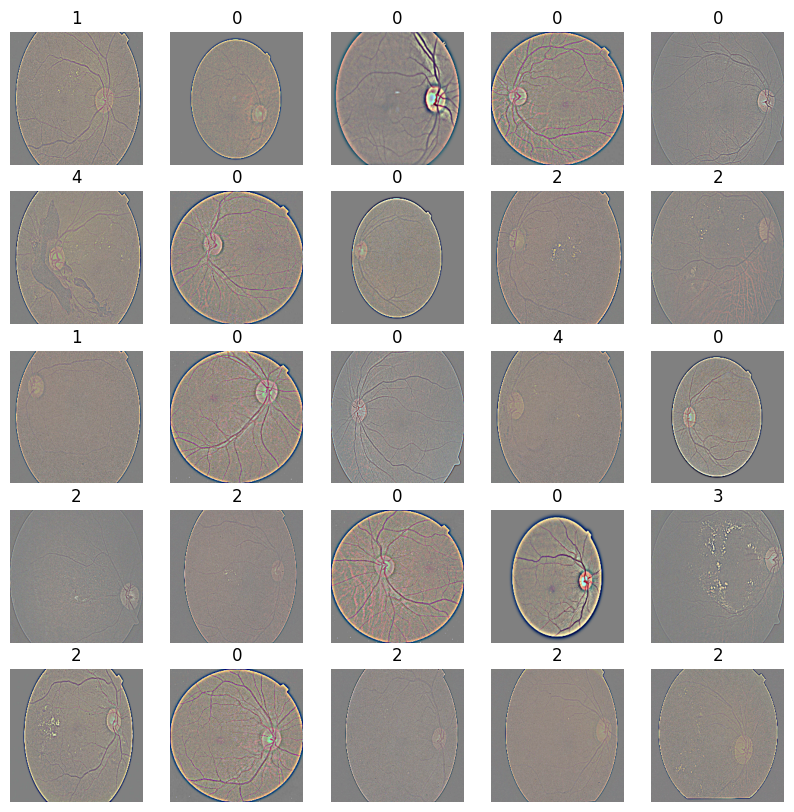

In [ ]:
# Now let's visualize the data in our training batch!
train_images, train_labels = next(train_data.as_numpy_iterator()) # Takes a batch from our batched dataset and turns it into iterable numpy array
show_25_images(train_images, train_labels)

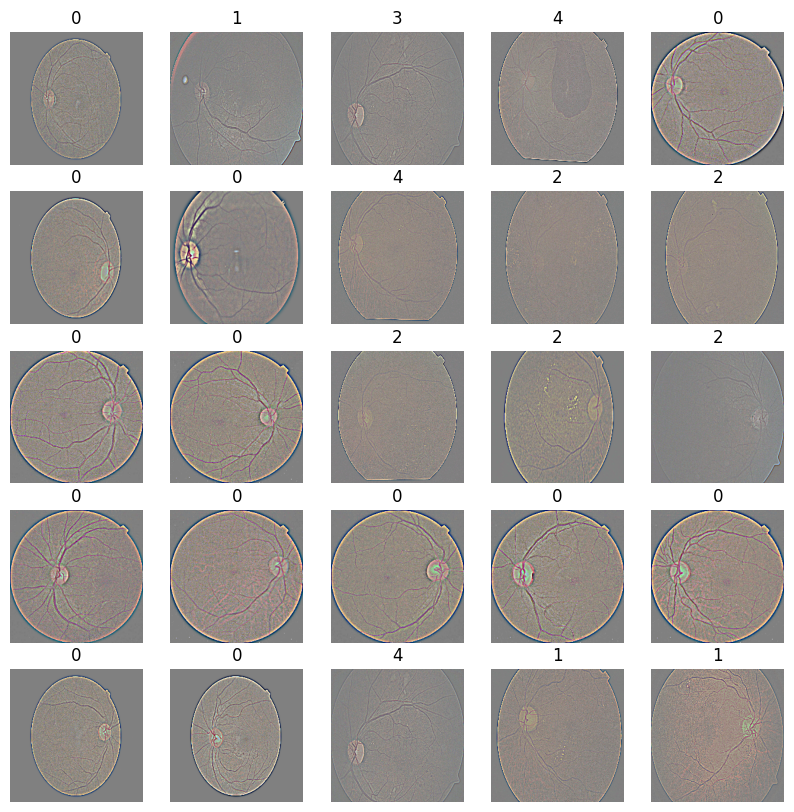

In [ ]:
# Now, let's visualize our validation set!

val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building A Model

Before we build a model, we need to define a few things:

* Input Shape (Our images shape, in the form of tensors) to our model
* Output Shape (Image Labels, in the form of tensors) to our model
* The Layers Of Our 2D CNN Model

In [ ]:
# Setup input shape
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3] # (batch size, height, width, color channels)

# Setup output shape
OUTPUT_SHAPE = len(unique_categories)

Now we've got out inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function that:
* Takes the input shape, output shape and the model that we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do first this, then this, then that)
* Compiles the model (Says it should be evaluated and improved)
* Builds the model (Tells the model the input shape it'd be getting)
* Returns the model.

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam

# Create a function which builds a Keras model
def create_model():

  tf.random.set_seed(1234)
  # Setting Up The Model Layers
  model = Sequential(
      [
          Conv2D(32, (3,3), activation = 'relu', input_shape = INPUT_SHAPE, name = 'Layer1'),
          MaxPooling2D((2,2), name = 'Layer2'),
          Conv2D(64, (3,3), activation = 'relu', name = 'Layer3'),
          MaxPooling2D((2,2), name = 'Layer4'),
          Conv2D(128, (3,3), activation = 'relu', name = 'Layer5'),
          MaxPooling2D((2,2), name = 'Layer6'),
          Conv2D(256, (3,3), activation = 'relu', name = 'Layer7'),
          MaxPooling2D((2,2), name = 'Layer8'),
          GlobalAveragePooling2D(name = 'Layer9'),
          Dense(512, activation = 'relu', name = 'Layer10'),
          Dropout(0.5, name = 'Layer11'),
          Dense(256, activation = 'relu', name = 'Layer12'),
          Dropout(0.5, name = 'Layer13'),
          Dense(128, activation = 'relu', name = 'Layer14'),
          Dropout(0.5, name = 'Layer15'),
          Flatten(name = 'Layer16'),
          Dense(units = OUTPUT_SHAPE, activation = 'softmax', name = 'Layer17') #Softmax Layer
      ]
  )

  # Compile The Model
  model.compile(
     loss = CategoricalCrossentropy(),
     optimizer = Adam(10e-3),
     metrics = ['accuracy']
  )

  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 Layer2 (MaxPooling2D)       (None, 111, 111, 32)      0         
                                                                 
 Layer3 (Conv2D)             (None, 109, 109, 64)      18496     
                                                                 
 Layer4 (MaxPooling2D)       (None, 54, 54, 64)        0         
                                                                 
 Layer5 (Conv2D)             (None, 52, 52, 128)       73856     
                                                                 
 Layer6 (MaxPooling2D)       (None, 26, 26, 128)       0         
                                                                 
 Layer7 (Conv2D)             (None, 24, 24, 256)      

## Creating Callbacks

Callbacks are helper functions that a model can use during training to do things such as saving its progress, checking its progress or stopping training early if the model stops improving.

We'll create two callbacks:
* TensorBoard : Track Progress
* Early Stopping : Prevent Training For Too Long (Overfitting / No Improvement)

### TensorBoard Callback

* Load the TensorBoard notebook extension ✅
* Create a TensorBoard callback to save logs to directory and pass it to our model's `fit()` function ✅
* Visualize our model's training logs with the `%tensorboard` magic function (After Training) ✅

In [ ]:
# Load TensorBoard Notebook Extension

%load_ext tensorboard
# Magic Function To Load Notebook Extension

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime
import os
from keras.callbacks import TensorBoard, EarlyStopping
# Create a function to build a TensorBoard Callback

def create_tensorboard_callback():

  # Create a log directory to store TensorBoard logs which get tracked whenever we run an experiment
  logdir = os.path.join("drive/MyDrive/DiabetesRetinopathy/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%m%s"))
  return TensorBoard(logdir)

### Early Stopping Callback

Early Stopping : Helps prevent overfitting by stopping our model's training when improvement is negligible

In [ ]:
# Create Early Stopping Callback ( Monitor - Value To Be Tracked For Stopping , Patience = No. Of Epochs To Tolerate)

early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 3)

## Training A Model (On Subset Of Data)

Our first model is going to train only on 1000 images, to make sure everything is working

In [ ]:
NUM_EPOCHS = 100 #@param {type: "slider", min: 10, max: 100}

y

In [ ]:
# Build a function to train and return a model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session whenever we train our model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])

  # Return the fitted model
  return model

In [ ]:
#  Fit the model to our data
model = train_model()

Epoch 1/100
92/92 [==============================] - 13s 129ms/step - loss: 1.1700 - accuracy: 0.5254 - val_loss: 1.0248 - val_accuracy: 0.6398
Epoch 2/100
92/92 [==============================] - 12s 135ms/step - loss: 1.0078 - accuracy: 0.6453 - val_loss: 0.9876 - val_accuracy: 0.6589
Epoch 3/100
92/92 [==============================] - 12s 128ms/step - loss: 0.9705 - accuracy: 0.6586 - val_loss: 0.9200 - val_accuracy: 0.6849
Epoch 4/100
92/92 [==============================] - 11s 118ms/step - loss: 0.9200 - accuracy: 0.6791 - val_loss: 0.8972 - val_accuracy: 0.7121
Epoch 5/100
92/92 [==============================] - 12s 134ms/step - loss: 0.8661 - accuracy: 0.6955 - val_loss: 0.8371 - val_accuracy: 0.7108
Epoch 6/100
92/92 [==============================] - 12s 127ms/step - loss: 0.8396 - accuracy: 0.7030 - val_loss: 0.8198 - val_accuracy: 0.7162
Epoch 7/100
92/92 [==============================] - 11s 119ms/step - loss: 0.8287 - accuracy: 0.7098 - val_loss: 0.8238 - val_accuracy:

In [ ]:
# Make predictions on the validation data (not used to train on)

predictions = model.predict(val_data, verbose = 1) # verbose -> print description of process
predictions

23/23 [==============================] - 31s 98ms/step


array([[9.99999166e-01, 3.46782571e-07, 4.77449873e-07, 1.58440674e-11,
        2.29663710e-09],
       [4.33290720e-01, 2.07087383e-01, 2.42413804e-01, 4.29734550e-02,
        7.42345676e-02],
       [4.17718664e-02, 3.02591622e-01, 3.91313553e-01, 1.02888517e-01,
        1.61434427e-01],
       ...,
       [1.00526335e-02, 1.38727382e-01, 5.12526155e-01, 1.42204031e-01,
        1.96489841e-01],
       [5.12373745e-01, 1.77675754e-01, 2.15118855e-01, 3.31684239e-02,
        6.16632029e-02],
       [5.67761213e-02, 3.60254616e-01, 3.56005549e-01, 8.66205394e-02,
        1.40343204e-01]], dtype=float32)

In [ ]:
predictions.shape # Probabilities of all 120 classes for all 200 images in validation data

(733, 5)

In [ ]:
# Checking Out A Prediction

index = 42
print(predictions[index])
print(f"Maximum Value (Probability Of Prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Maximum Index: {np.argmax(predictions[index])}")
print(f"Predicted Label: {labels_dict[unique_categories[np.argmax(predictions[index])]]}")

[9.9999976e-01 1.1134378e-07 1.4996982e-07 2.3647521e-12 5.0346255e-10]
Maximum Value (Probability Of Prediction): 0.9999997615814209
Sum: 1.0
Maximum Index: 0
Predicted Label: No_DR


It would be great if we could see the image the prediction is being made on

**Note**: Prediction Probabilities = Confidence Intervals

In [ ]:
# Turn prediction probabilities into their respective label (Easy To Understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a prediction label
  """
  return labels_dict[unique_categories[np.argmax(prediction_probabilities)]]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[42])
pred_label

'No_DR'

Since our validation data is a batched dataset, we'll have to unbatch it to make predictions on the validation images and compare them to the truth labels

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.bool, name=None))>

In [ ]:
# Create a function to unbatch a batched dataset

def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and return separate arrays of images and labels
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(get_pred_label(label))

  return images, labels

In [ ]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608]],
 
        [[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608]],
 
        [[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         ...,
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608]],
 
        ...,
 
        [[0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         [0.5019608, 0.5019608, 0.5019608],
         .

Now we have:
* Predicted Labels
* Validation / Truth Labels
* Validation Images

Let's make it a bit more visual :D

We'll create a function which:
* Takes an array of predicted probabilities, an array of truth labels and an array of images and an integer. ✅
* Converts the predicted probabilities to a predicted label ✅
* Plots the target image, its predicted label, and its truth label on a single plot ✅

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n = 1):
  """
  View the prediction, ground truth and image for sample 'n'
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get The Predicted Label
  pred_label = get_pred_label(pred_prob)

  # Plot Image & Remove Ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change The Colour Of The Title Depending On Right / Wrong Prediction
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change Plot Title
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color = color)

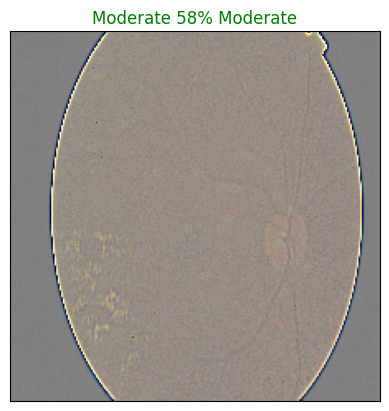

In [ ]:
plot_pred(prediction_probabilities = predictions, labels = val_labels, images = val_images, n = 400)

Let's make a function to view our model's predictions

This function will:
* Take inputs as prediction probabilities array, ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find all 5:
  * Prediction Probabilities Indexes
  * Prediction Probabilities Values
  * Predictiion Labels
* Plot the prediction probability values and labels, colouring the true label green

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n = 1):
  """
  Plot the prediction confidences along with the truth label for sample n:
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the prediction probability/confidence indexes
  pred_indexes = pred_prob.argsort()[::-1]

  # Find the prediction probability/confidence values
  pred_values = pred_prob[pred_indexes]

  # Find the prediction labels
  pred_labels = [labels_dict[i] for i in unique_categories[pred_indexes]]

  # Setup plot
  top_plot = plt.bar(np.arange(len(pred_labels)),
                     pred_values,
                     color="grey")

  # Number of bars on x-axis = No. of labels
  plt.xticks(np.arange(len(pred_labels)),
             labels = pred_labels,
             rotation = "vertical")

  # Change color of true label
  if np.isin(true_label, pred_labels): # If first argument is present in second argument
    top_plot[np.argmax(pred_labels == np.array(true_label))].set_color("green") # Set color of true label bar to green
  else:
    pass

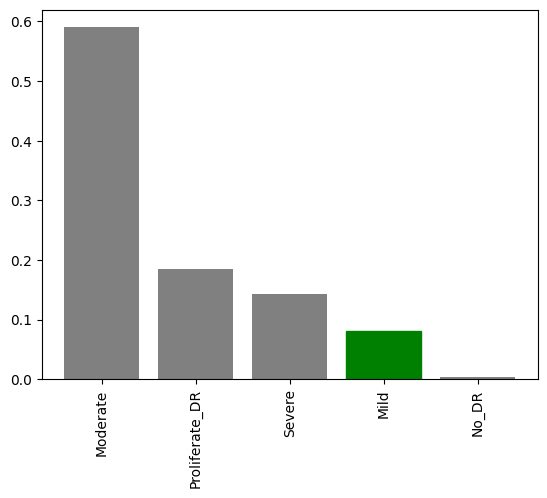

In [ ]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = val_labels,
               n = 70);

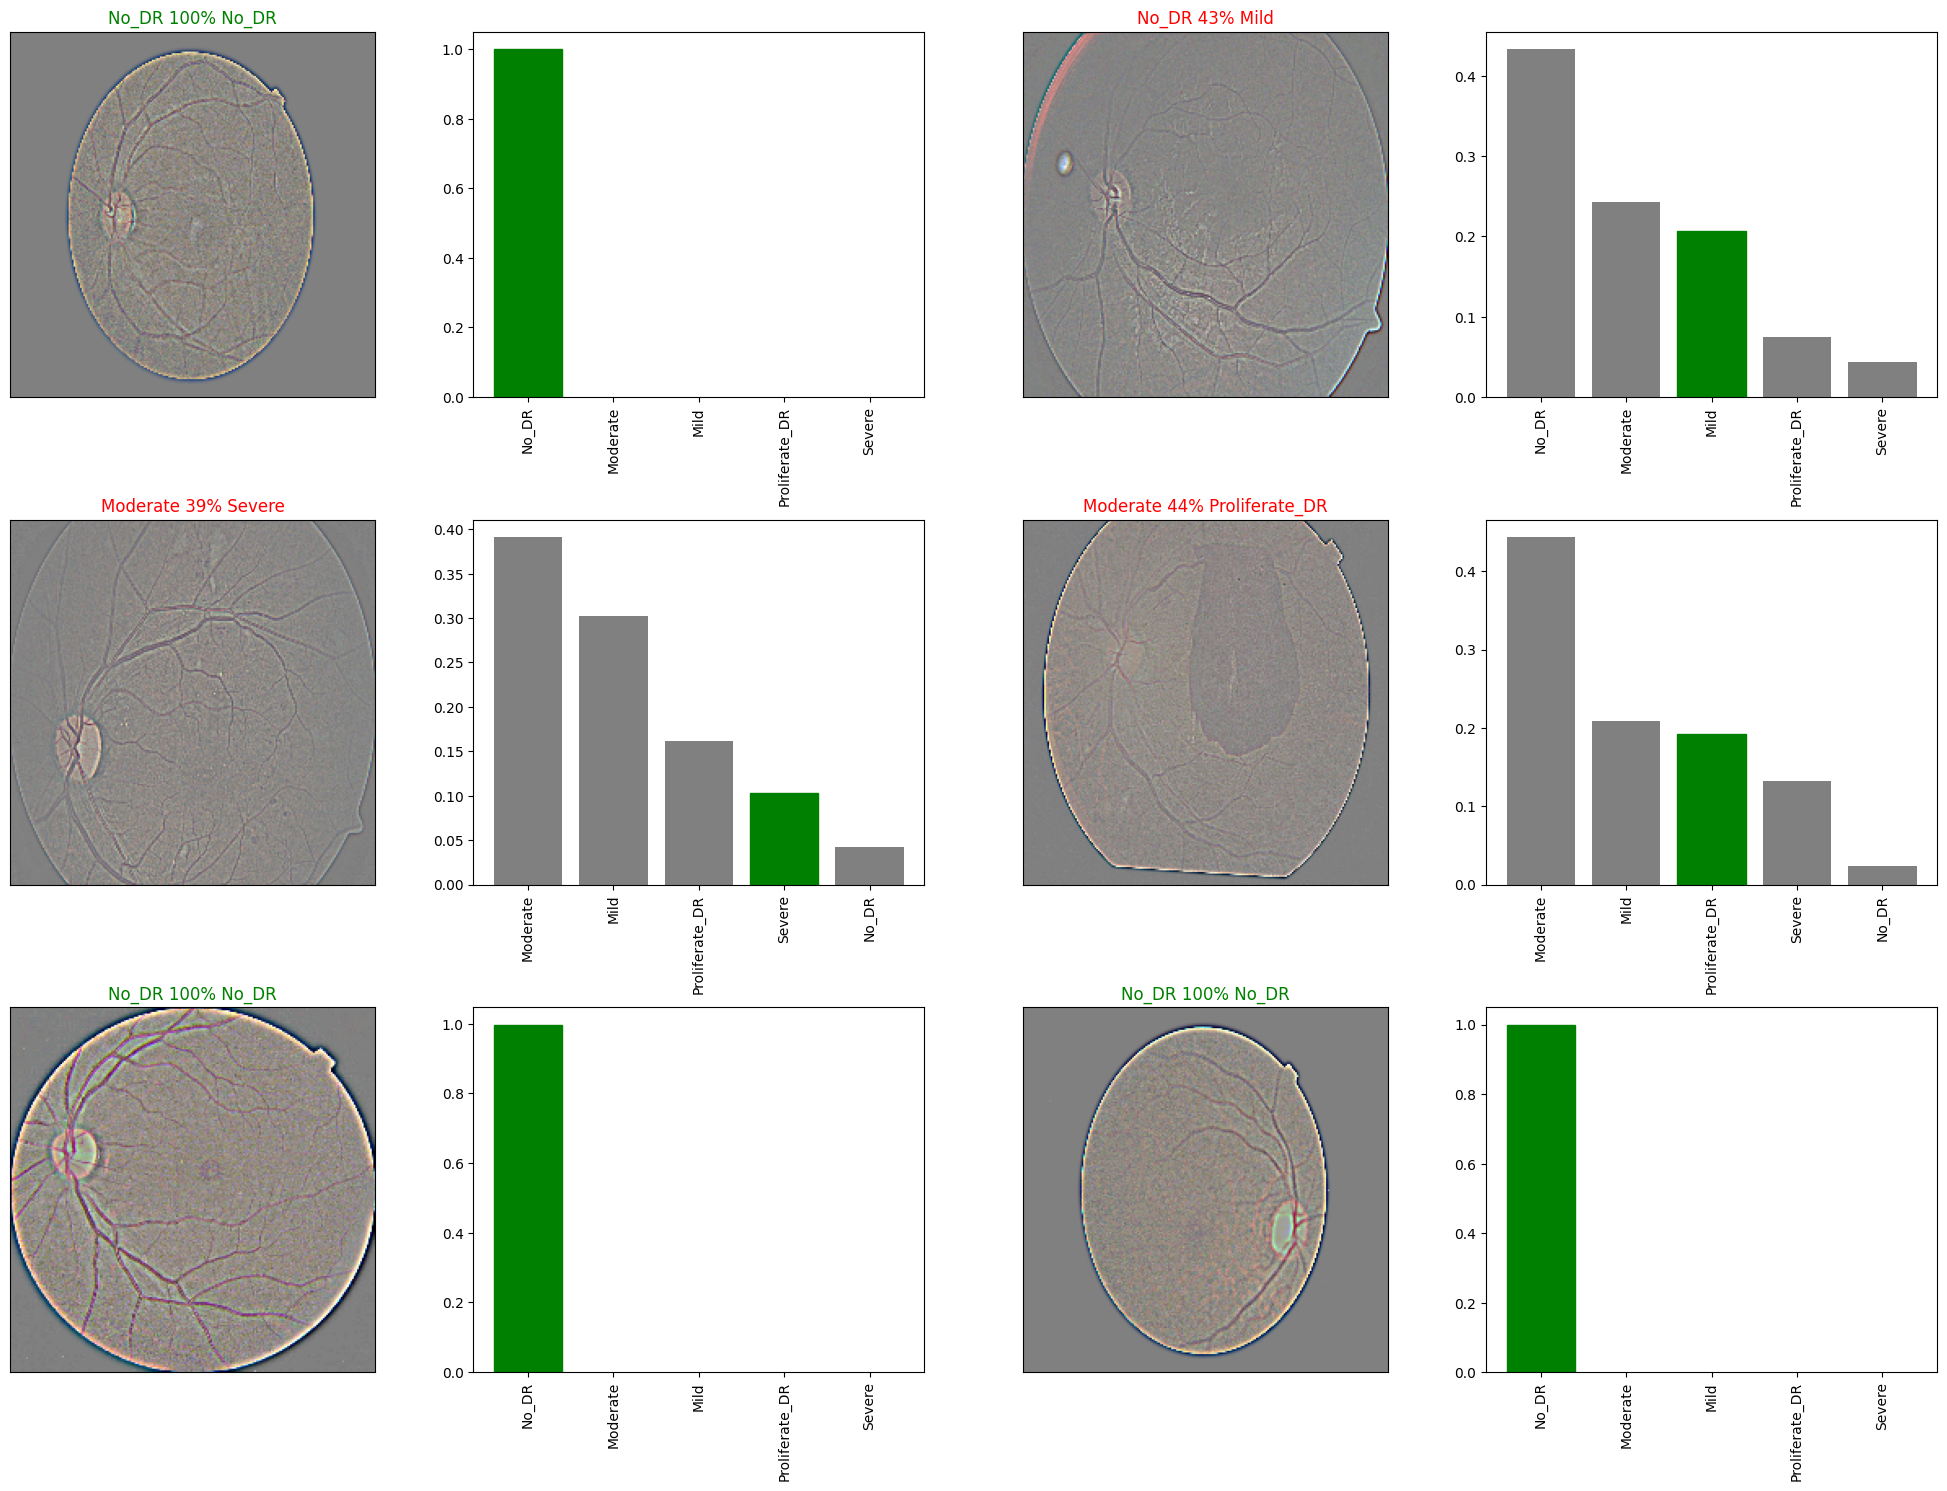

In [ ]:
# Let's check out a few predictions and their different values

i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize = (10 * num_cols, 5 * num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2*i + 1)
  plot_pred(prediction_probabilities = predictions,
            labels = val_labels,
            images = val_images,
            n = i + i_multiplier)
  plt.subplot(num_rows, 2 * num_cols, 2*i + 2)
  plot_pred_conf(prediction_probabilities = predictions,
                 labels = val_labels,
                 n = i + i_multiplier)
plt.tight_layout(h_pad = 1.0)
plt.show()

## Saving & Reloading A Trained Model

In [ ]:
# Create a function to save a model

def save_model(model, suffix = None):
  """
  Saves a given model in our models directory and appends a suffix (string)
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/DiabeticRetinopathy/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%m%s"))
  model_path = modeldir + "-" + suffix + ".h5" # Save format of model
  print(f"Saving Model To : {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model

def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading Saved Model From: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer": hub.KerasLayer})
  return model

Let's make sure it works!

In [ ]:
# Save our model

save_model(model, suffix = "diabetic-retinopathy-2dcnn")

Saving Model To : drive/MyDrive/DiabeticRetinopathy/models/20230405-11041680694614-diabetic-retinopathy-2dcnn.h5...


'drive/MyDrive/DiabeticRetinopathy/models/20230405-11041680694614-diabetic-retinopathy-2dcnn.h5'

In [ ]:
# Load our model

loaded_model = load_model("drive/MyDrive/DiabeticRetinopathy/models/20230405-11041680694614-diabetic-retinopathy-2dcnn.h5")

Loading Saved Model From: drive/MyDrive/DiabeticRetinopathy/models/20230405-11041680694614-diabetic-retinopathy-2dcnn.h5


In [ ]:
# Evaluate the pre-saved model

model.evaluate(val_data)

23/23 [==============================] - 2s 81ms/step - loss: 0.7010 - accuracy: 0.7422


[0.7009667158126831, 0.7421555519104004]

In [ ]:
# Evaluate the loaded model

loaded_model.evaluate(val_data)

23/23 [==============================] - 4s 136ms/step - loss: 0.7010 - accuracy: 0.7422


[0.7009667158126831, 0.7421555519104004]

## Training Our Model On The Full Dataset!

In [ ]:
len(X), len(y)

(3662, 3662)

In [ ]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
# Create a model for full data

full_model = create_model()

In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all data, we can't monitor validation accuracy
full_model_early_stopping = EarlyStopping(monitor = "accuracy",
                                          patience = 3)

In [ ]:
# Fit the full model to the full data

full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
115/115 [==============================] - 13s 99ms/step - loss: 1.1689 - accuracy: 0.5180
Epoch 2/100
115/115 [==============================] - 11s 96ms/step - loss: 0.9872 - accuracy: 0.6546
Epoch 3/100
115/115 [==============================] - 11s 94ms/step - loss: 0.9374 - accuracy: 0.6759
Epoch 4/100
115/115 [==============================] - 12s 100ms/step - loss: 0.9142 - accuracy: 0.6881
Epoch 5/100
115/115 [==============================] - 11s 97ms/step - loss: 0.8816 - accuracy: 0.6983
Epoch 6/100
115/115 [==============================] - 10s 90ms/step - loss: 0.8617 - accuracy: 0.7062
Epoch 7/100
115/115 [==============================] - 11s 92ms/step - loss: 0.8273 - accuracy: 0.7138
Epoch 8/100
115/115 [==============================] - 11s 96ms/step - loss: 0.8136 - accuracy: 0.7193
Epoch 9/100
115/115 [==============================] - 11s 94ms/step - loss: 0.7955 - accuracy: 0.7190
Epoch 10/100
115/115 [==============================] - 11s 98ms/step - 

In [ ]:
save_model(full_model, suffix = "full-image-retinopathy")

Saving Model To : drive/MyDrive/DiabeticRetinopathy/models/20230405-12041680696749-full-image-retinopathy.h5...


'drive/MyDrive/DiabeticRetinopathy/models/20230405-12041680696749-full-image-retinopathy.h5'

In [ ]:
# Load in the saved model

loaded_full_model = load_model("drive/MyDrive/DiabeticRetinopathy/models/20230405-12041680696749-full-image-retinopathy.h5")

Loading Saved Model From: drive/MyDrive/DiabeticRetinopathy/models/20230405-12041680696749-full-image-retinopathy.h5


In [ ]:
!unzip "/content/drive/MyDrive/retina_test.zip" -d "drive/MyDrive/DiabeticRetinopathy/retina-test-photos"

Archive:  /content/drive/MyDrive/retina_test.zip
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29110_left.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29110_right.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29113_right.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29114_right.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29107_right.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29117_right.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29107_left.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29117_left.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29109_left.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29109_right.jpeg  
  inflating: drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29106_left.jpeg  
  inflating: drive/My

## Making Predictions On Custom Images

To make predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()` and since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to our prediction labels.
* Compare the predicted labels to custom images.

In [ ]:
# Get custom image filepaths
custom_path = "drive/MyDrive/DiabeticRetinopathy/retina-test-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29110_left.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29110_right.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29113_right.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29114_right.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29107_right.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29117_right.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29107_left.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29117_left.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29109_left.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29109_right.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29106_left.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29113_left.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-test-photos/29106_right.jpeg',
 'drive/MyDrive/DiabeticRetinopathy/retina-t

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on the custom data
custom_preds= loaded_full_model.predict(custom_data)

1/1 [==============================] - 3s 3s/step


In [ ]:
custom_preds.shape

(14, 5)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['Moderate',
 'No_DR',
 'Moderate',
 'No_DR',
 'Moderate',
 'No_DR',
 'No_DR',
 'No_DR',
 'No_DR',
 'No_DR',
 'No_DR',
 'Moderate',
 'No_DR',
 'Moderate']

In [ ]:
# Get custom images
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

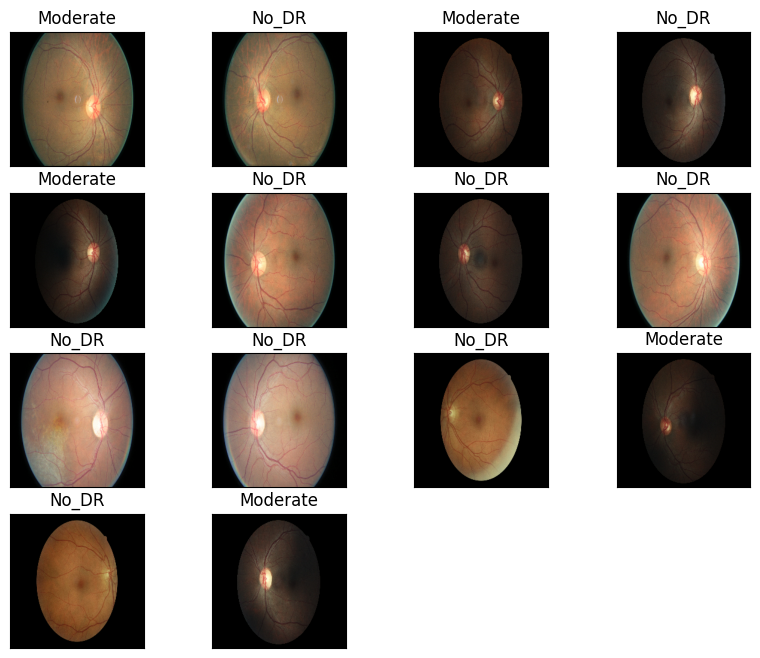

In [ ]:
# Check custom image predictions
plt.figure(figsize = (10,8))
for i, image in enumerate(custom_images):
  plt.subplot(4, 4, i+1) # Rows, column, index
  plt.xticks([])
  plt.yticks([]) # No need of ticks, set empty array
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

In [ ]:
loaded_full_model.evaluate(val_data)

23/23 [==============================] - 3s 110ms/step - loss: 0.0743 - accuracy: 0.9754


[0.07431449741125107, 0.9754433631896973]

## Successfully built end-to-end diabetic retinopathy model (~ 97% training & val accuracy)